In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


In [4]:
train_data = datasets.CIFAR10(root = "data", train = True, download = True, transform = train_transform)
test_data = datasets.CIFAR10(root = "data", train = False, download = True, transform = test_transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13133260.94it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
image, label = train_data[0]
image, label

(tensor([[[-2.1771e+00, -2.1771e+00, -2.1771e+00,  ..., -2.1771e+00,
           -2.1771e+00, -2.1771e+00],
          [-2.1771e+00, -2.1771e+00, -2.1771e+00,  ..., -1.2660e+00,
           -2.1771e+00, -2.1771e+00],
          [-2.1771e+00,  7.6945e-01,  9.4391e-01,  ..., -8.7827e-01,
           -2.1771e+00, -2.1771e+00],
          ...,
          [-2.1771e+00, -2.1771e+00, -5.9512e-03,  ...,  1.3704e+00,
            1.1959e+00, -2.1771e+00],
          [-2.1771e+00, -2.1771e+00, -8.7827e-01,  ..., -2.1771e+00,
           -2.1771e+00, -2.1771e+00],
          [-2.1771e+00, -2.1771e+00, -2.1771e+00,  ..., -2.1771e+00,
           -2.1771e+00, -2.1771e+00]],
 
         [[-2.1626e+00, -2.1626e+00, -2.1626e+00,  ..., -2.1626e+00,
           -2.1626e+00, -2.1626e+00],
          [-2.1626e+00, -2.1626e+00, -2.1626e+00,  ..., -1.3562e+00,
           -2.1626e+00, -2.1626e+00],
          [-2.1626e+00,  7.0877e-01,  8.6611e-01,  ..., -9.4324e-01,
           -2.1626e+00, -2.1626e+00],
          ...,
    

In [6]:
image.shape, label

(torch.Size([3, 32, 32]), 6)

In [7]:
class_name = train_data.classes

In [8]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
len(train_data), len(test_data)

(50000, 10000)

Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, '6')

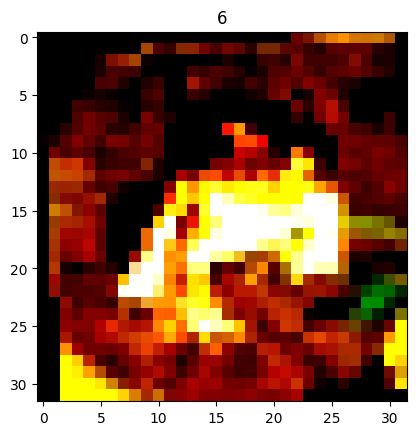

In [10]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1,2,0).squeeze())
plt.title(label)

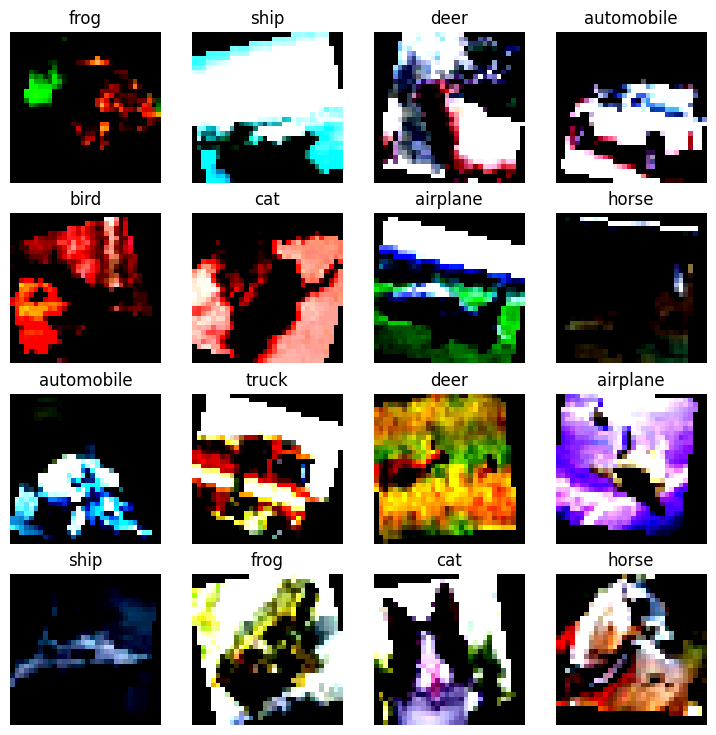

In [11]:
fig = plt.figure(figsize=(9,9))
row,cols = 4,4
for i in range(1,row*cols+1):
  random_idx = torch.randint(0,len(train_data),(1,)).item()
  image, label = train_data[random_idx]
  fig.add_subplot(row,cols,i)
  plt.imshow(image.permute(1,2,0).squeeze())
  plt.title(class_name[label])
  plt.axis(False)

Training

In [12]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [13]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [14]:
import torch
import torch.nn as nn

class CIFARModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, output_shape: int) -> None:
        super().__init__()

        # Convolutional Block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units_1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units_1, out_channels=hidden_units_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half
        )

        # Convolutional Block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units_1, out_channels=hidden_units_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units_2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units_2, out_channels=hidden_units_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units_2 * 8 * 8, out_features=512),  # Increase hidden units
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)

        x = self.classifier(x)
        return x


In [15]:
model_0 = CIFARModel(input_shape=3, hidden_units_1 = 32,hidden_units_2 = 64, output_shape=10)
model_0.to(device)

CIFARModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [17]:
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARNING_RATE, weight_decay = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)
early_stopping = EarlyStopping(patience=5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
  ):
  model.train()
  train_loss, train_acc = 0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
  ):
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_logits)
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

### Creating a train() function to combine the train_step and test step
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 20,
          device: torch.device = device):

  results = {'train_loss':[],
             'train_acc':[],
             'test_loss':[],
             'test_acc':[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)



    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    scheduler.step(test_loss)

    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        model.load_state_dict(early_stopping.best_model_weights)
        break

  return results

In [19]:
NUM_EPOCHS = 20
# start the timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.7431 | Train acc: 0.3564 | Test loss: 1.3835 | Test acc: 0.4896
Epoch: 2 | Train loss: 1.4431 | Train acc: 0.4786 | Test loss: 1.0582 | Test acc: 0.6065
Epoch: 3 | Train loss: 1.3112 | Train acc: 0.5298 | Test loss: 0.9483 | Test acc: 0.6627
Epoch: 4 | Train loss: 1.2130 | Train acc: 0.5700 | Test loss: 0.9974 | Test acc: 0.6470
Epoch: 5 | Train loss: 1.1254 | Train acc: 0.6024 | Test loss: 0.8386 | Test acc: 0.6973
Epoch: 6 | Train loss: 1.0603 | Train acc: 0.6281 | Test loss: 0.7646 | Test acc: 0.7227
Epoch: 7 | Train loss: 1.0037 | Train acc: 0.6506 | Test loss: 0.7539 | Test acc: 0.7340
Epoch: 8 | Train loss: 0.9548 | Train acc: 0.6680 | Test loss: 0.6853 | Test acc: 0.7595
Epoch: 9 | Train loss: 0.9207 | Train acc: 0.6773 | Test loss: 0.6999 | Test acc: 0.7568
Epoch: 10 | Train loss: 0.8912 | Train acc: 0.6903 | Test loss: 0.6490 | Test acc: 0.7702
Epoch: 11 | Train loss: 0.8655 | Train acc: 0.7026 | Test loss: 0.6405 | Test acc: 0.7749
Epoch: 12 | Train l

Evaluation

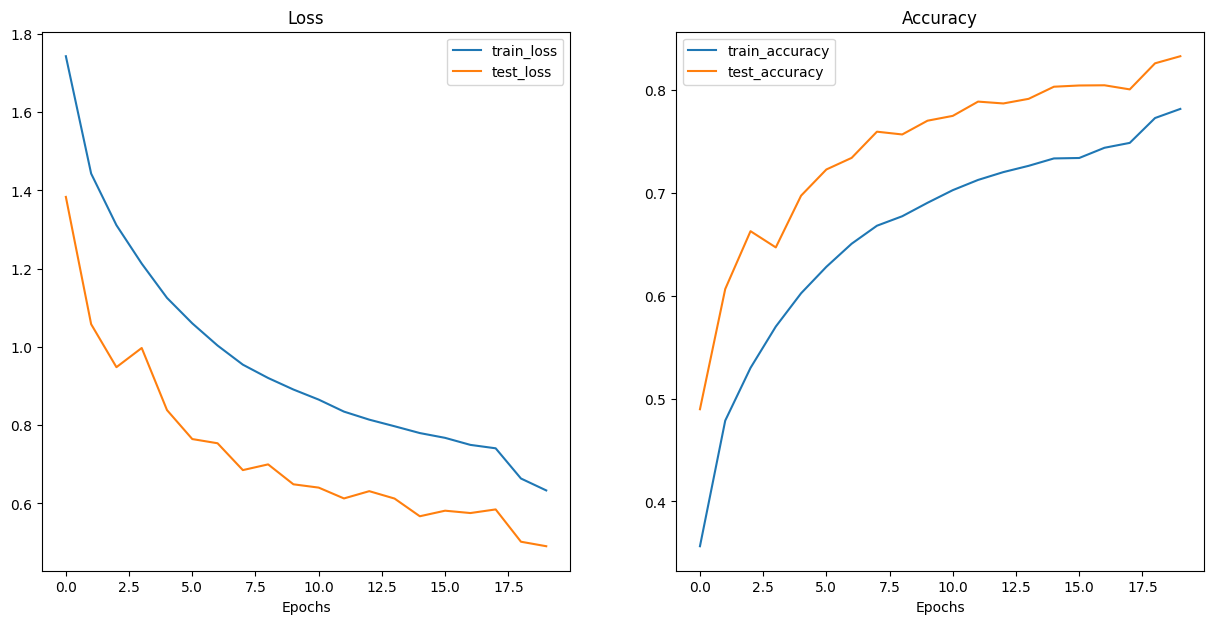

In [20]:
import matplotlib.pyplot as plt
from typing import Dict, List
def plot_loss_curves(results :Dict[str, List[float]]):
  '''plots training curves of the result dictionary'''
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']
  #Figure out how many epoch there were
  epochs = range(len(results['train_loss']))

  #setup a plot
  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(model_0_results)

In [30]:
def make_prediction(model:torch.nn.Module,
                    data:list,
                    device:torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)

      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)


In [31]:
import random
test_samples =[]
test_labels = []
for sample, label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape


torch.Size([3, 32, 32])

In [32]:
pred_probs = make_prediction(model=model_0,data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

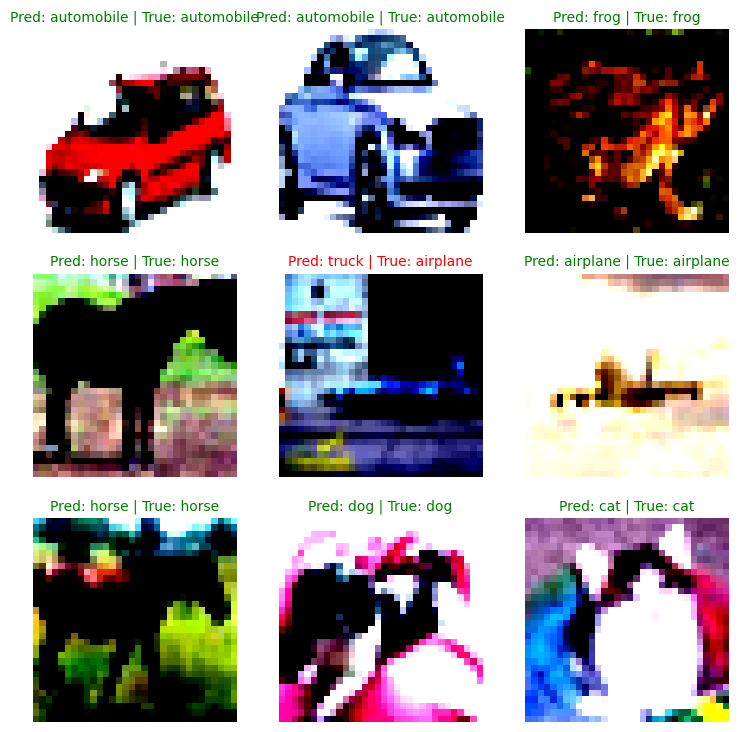

In [33]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows,ncols,i+1)

  plt.imshow(sample.permute(1,2,0),cmap = "gray")

  pred_label = class_name[pred_classes[i]]

  true_label = class_name[test_labels[i]]

  title_test = f"Pred: {pred_label} | True: {true_label}"

  if pred_label == true_label:
    plt.title(title_test,c="g",fontsize = 10)
  else:
    plt.title(title_test,c="r",fontsize = 10)

  plt.axis(False)

In [40]:
import torchmetrics
import numpy as np

confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=10)
confusion_matrix = confusion_matrix.to(device)

In [41]:
all_preds = []
all_labels = []

model_0.eval()
with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_0(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        confusion_matrix.update(predicted, labels)

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
cm = confusion_matrix.compute().cpu().numpy()

print(f'Confusion Matrix:\n{cm}')


Confusion Matrix:
[[873  17  29   8   5   0   4  13  33  18]
 [  4 954   0   2   0   0   2   1   7  30]
 [ 53   2 727  40  50  34  49  34   4   7]
 [ 14   1  48 678  34 124  49  33  11   8]
 [ 17   2  43  42 790  18  31  52   4   1]
 [ 13   2  28 117  29 753  12  40   2   4]
 [  4   2  38  52  20  12 863   3   4   2]
 [ 19   0  19  27  12  26   4 884   0   9]
 [ 51  16   4   4   3   0   2   3 902  15]
 [ 19  50   4   8   0   0   0   2  13 904]]


In [42]:
from mlxtend.plotting import plot_confusion_matrix

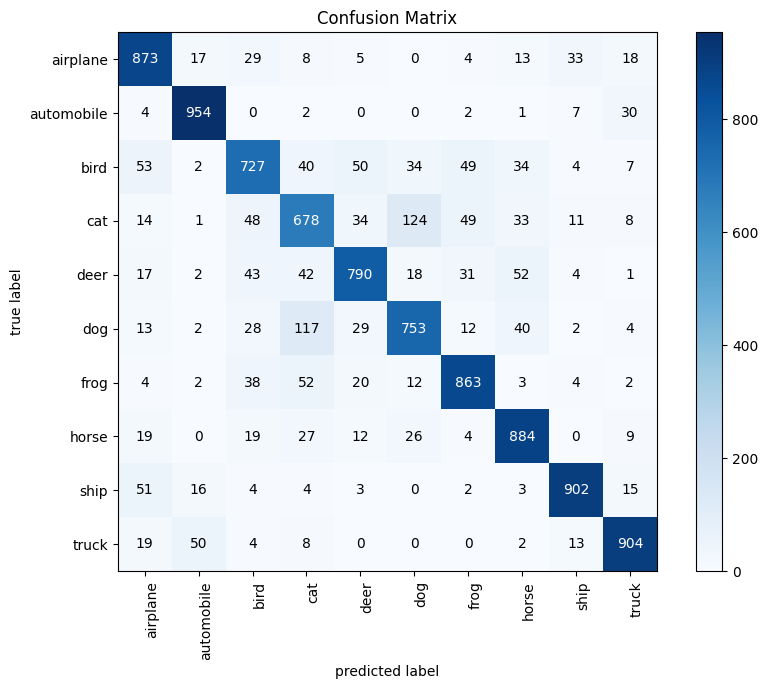

In [47]:
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,7), colorbar=True, class_names=range(10))
plt.xticks(range(10), class_name, rotation=90)
plt.yticks(range(10), class_name)
plt.title('Confusion Matrix')
plt.show()

Saving the model

In [50]:
from pathlib import Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Image Classification model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: model/Image Classification model.pth
